In [1]:
''' Import packages/modules. '''

import sys
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.interpolate import interp1d
import pywt
import numpy as np
import math
from copy import deepcopy
from scipy.fft import rfft, irfft, rfftfreq
from scipy import signal
import scipy.interpolate as sint

sys.path.insert(0, '/home/elott1/code')

from ColorDataUtils.DDPIutils import DDPIutils
from NDNT.utils import DanUtils as DU

%load_ext autoreload
%autoreload 2

Invoking __init__.py for NDNT.utils


In [2]:
''' Load data into seperate trials. '''

datadir = '/home/dbutts/ColorV1/Data/'
f = 'Jocamo0331_dpi_calibrated'

data = DDPIutils(filename=f, data_dir=datadir)

Seperating trials...
Done.


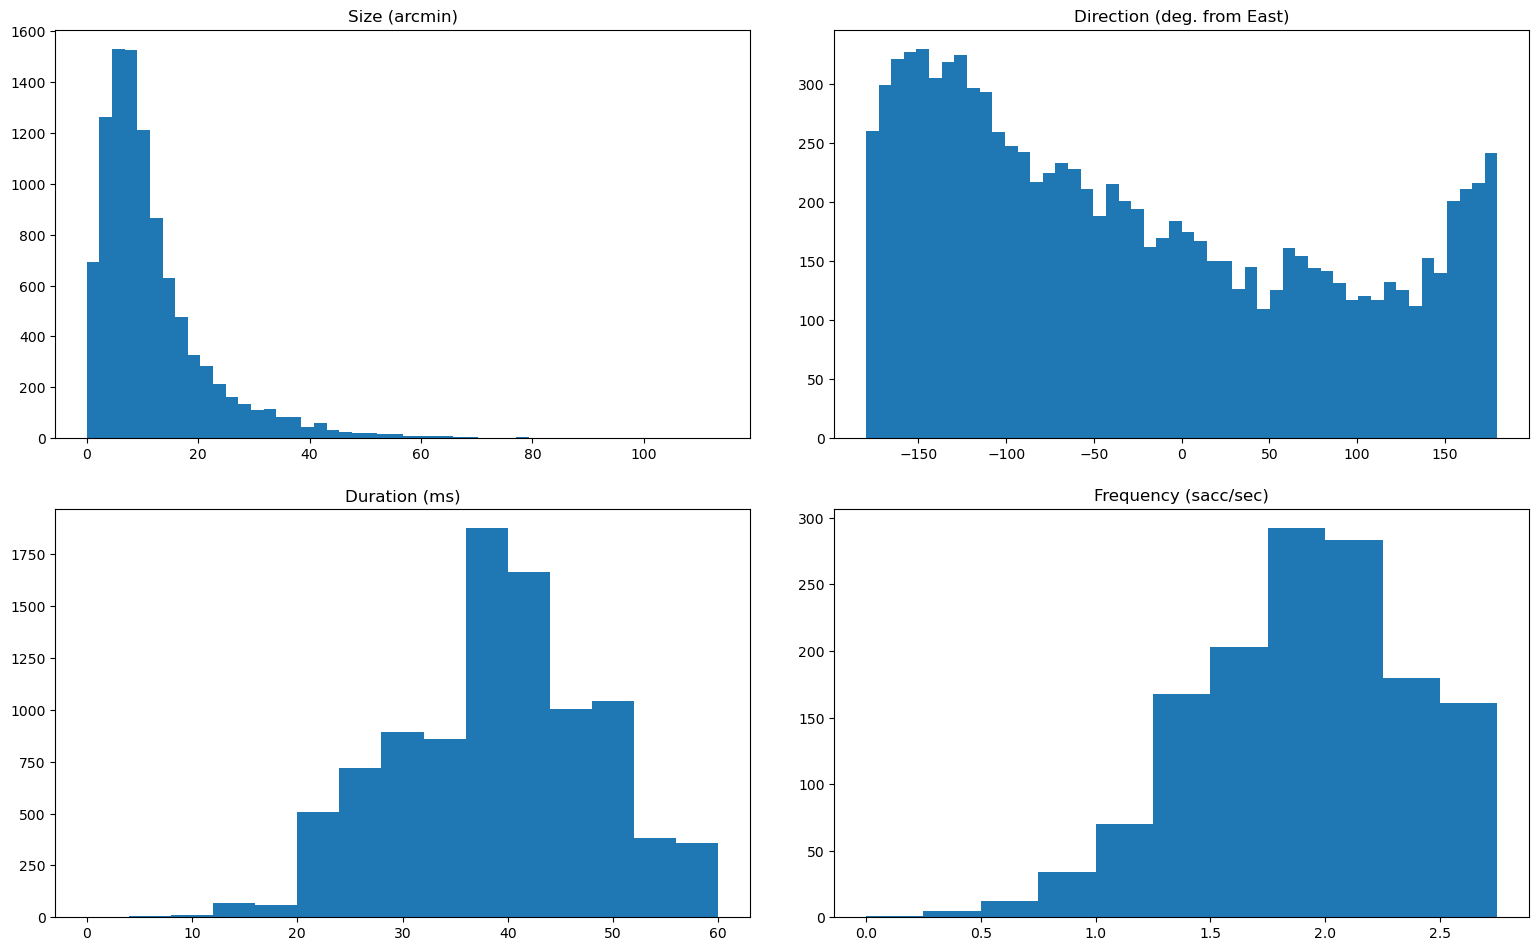

In [3]:
''' Process all trials and view distributions of saccade stats. Takes about 1 min. per 200 trials. '''

for i in range(data.num_trials):
    data.process_trial(tr=i, verbose=False)
    data.process_fixations(tr=i)

data.saccade_stats()

In [19]:
all_saccs = np.zeros(0)
for saccs in data.sacc_sizes:
    all_saccs = np.concatenate([all_saccs, saccs])

med_size = np.median(all_saccs)
small_sacc = np.where(all_saccs < med_size)[0]
big_sacc = np.where(all_saccs > med_size)[0]

Mean startRad: 7.832181155069339
Mean endRad: 7.962267134085238
Mean dRad: 0.13008597901589972


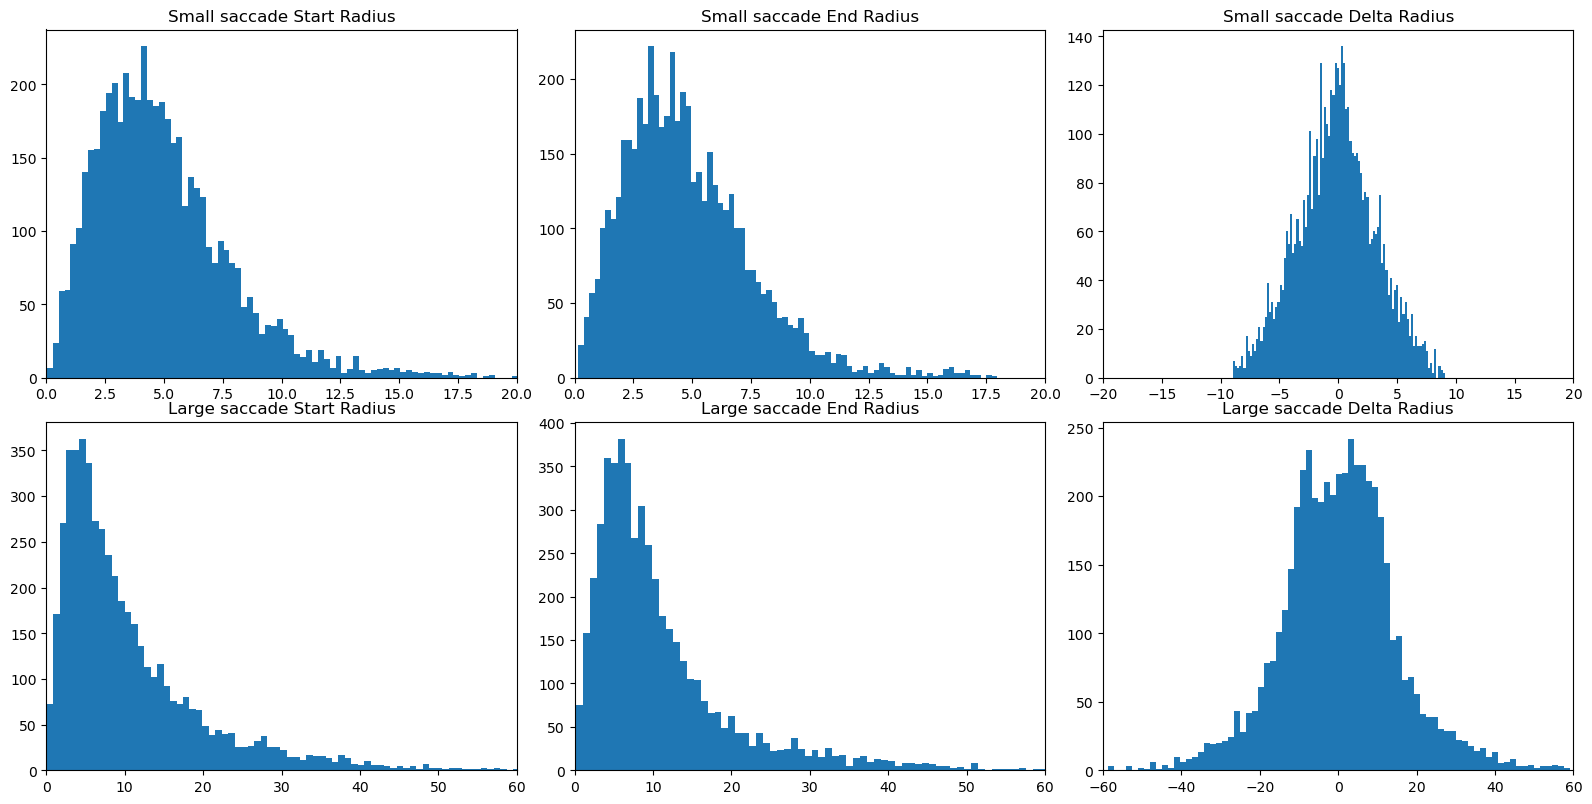

In [24]:
''' Check for patterns in saccade behavior. '''

dr = np.zeros([0,1])
start = np.zeros(0)
end = np.zeros(0)
for i, rad in enumerate(data.sacc_rads):
    if data.num_sacc[i] > 0:
        start = np.concatenate([start, rad[:,0]])
        end = np.concatenate([end, rad[:,1]])
        dr = np.concatenate([dr, np.diff(rad, axis=1)])
dr = dr.squeeze()
start = start.squeeze()
end = end.squeeze()

print(f'Mean startRad: {start.mean()}')
print(f'Mean endRad: {end.mean()}')
print(f'Mean dRad: {dr.mean()}')

DU.ss(2,3,rh=4)
plt.subplot(231)
plt.title('Small saccade Start Radius')
plt.xlim(0,20)
plt.hist(start[small_sacc], bins=100)
plt.subplot(232)
plt.title('Small saccade End Radius')
plt.xlim(0,20)
plt.hist(end[small_sacc], bins=100)
plt.subplot(233)
plt.title('Small saccade Delta Radius')
plt.xlim(-20,20)
plt.hist(dr[small_sacc], bins=100)
plt.subplot(234)
plt.title('Large saccade Start Radius')
plt.xlim(0,60)
plt.hist(start[big_sacc], bins=100)
plt.subplot(235)
plt.title('Large saccade End Radius')
plt.xlim(0,60)
plt.hist(end[big_sacc], bins=100)
plt.subplot(236)
plt.title('Large saccade Delta Radius')
plt.xlim(-60,60)
plt.hist(dr[big_sacc], bins=100)
plt.show()

In [73]:
total_fixes = data.num_sacc.sum() + data.num_trials

avg_fix_point = np.zeros([total_fixes, 2])
i = 0

for fixes in data.fix_avg_et:
    for fix in fixes:
        avg_fix_point[i] = fix[:,1:].mean(axis=0) if fix.shape[0] > 0 else 0
        i += 1

avg_fix_point = np.delete(avg_fix_point, np.unique(np.where(avg_fix_point==0)), axis=0)

Mean fixation x: 1.075001322242844
Mean fixation y: -0.5636474700463506


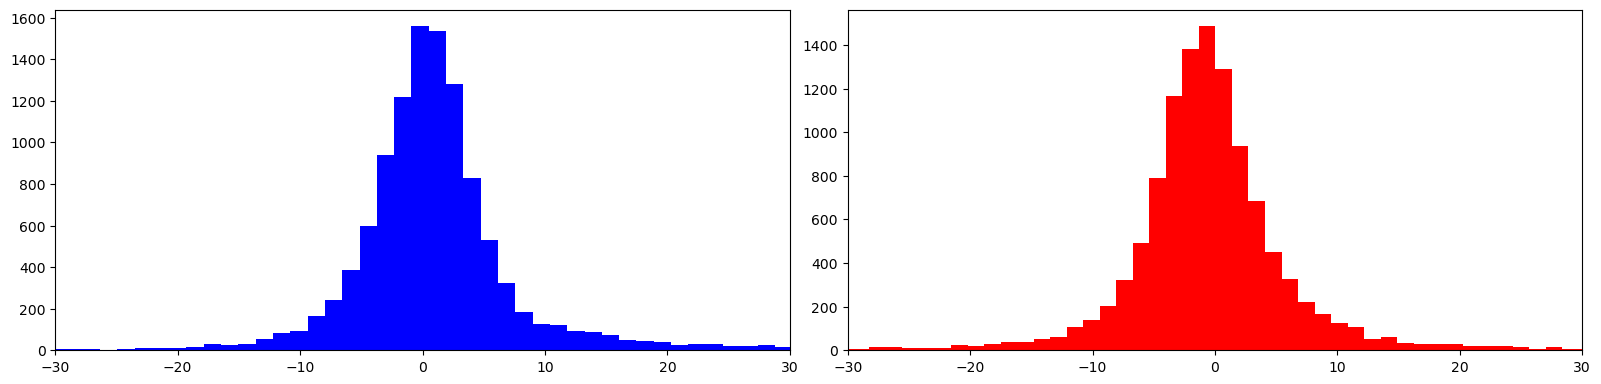

In [75]:
avgs = avg_fix_point.mean(axis=0)
print(f'Mean fixation x: {avgs[0]}')
print(f'Mean fixation y: {avgs[1]}')
DU.ss(1,2,rh=4)
plt.subplot(121)
plt.hist(avg_fix_point[:,0], bins=100, color='blue')
plt.xlim(-30, 30)
plt.subplot(122)
plt.hist(avg_fix_point[:,1], bins=100, color='red')
plt.xlim(-30, 30)
plt.show()

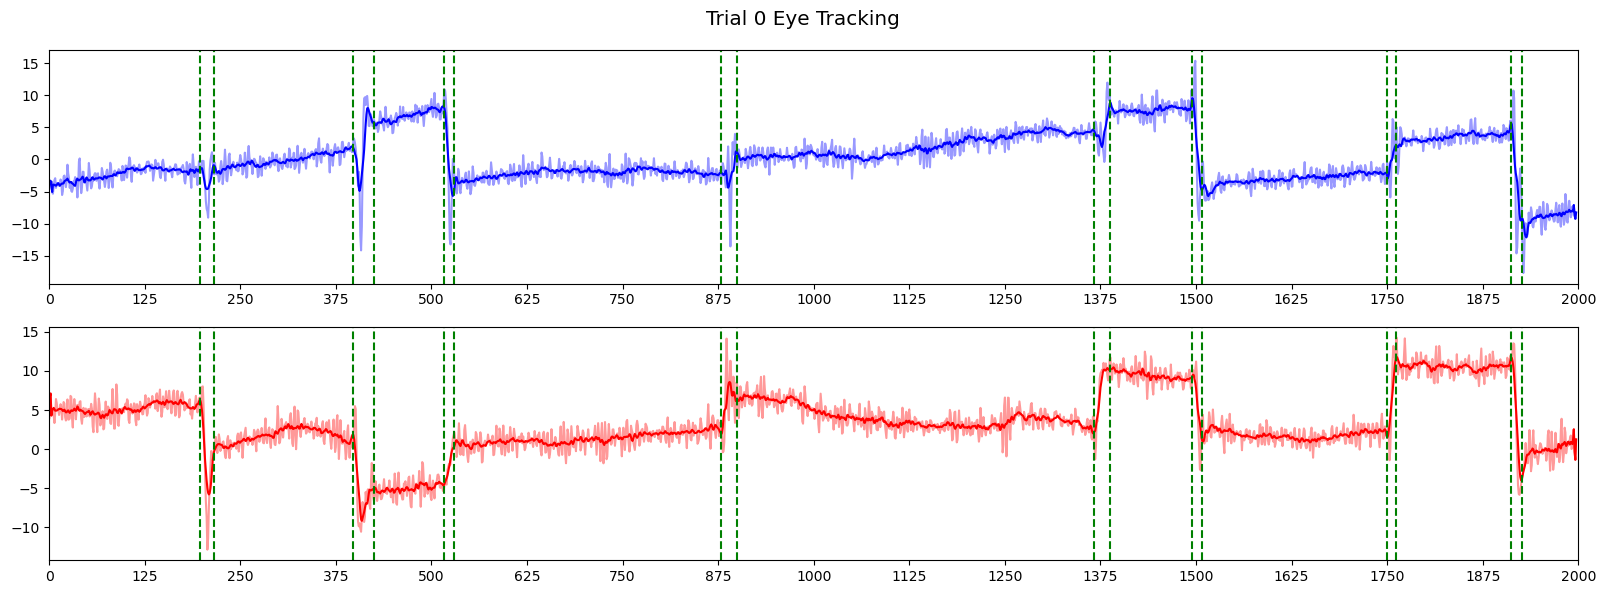

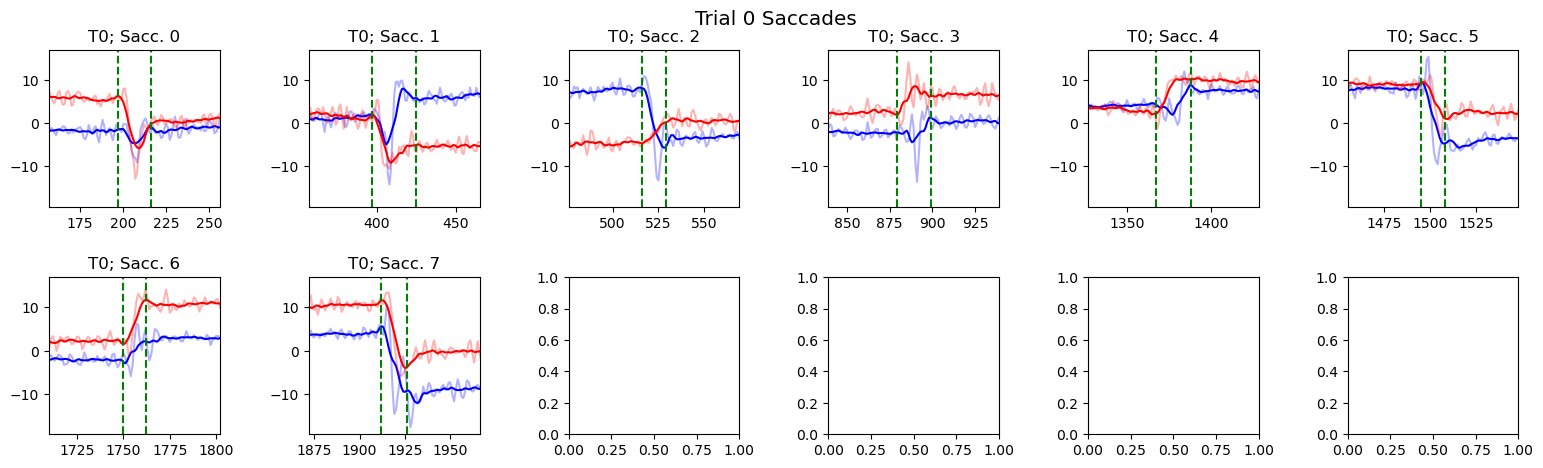

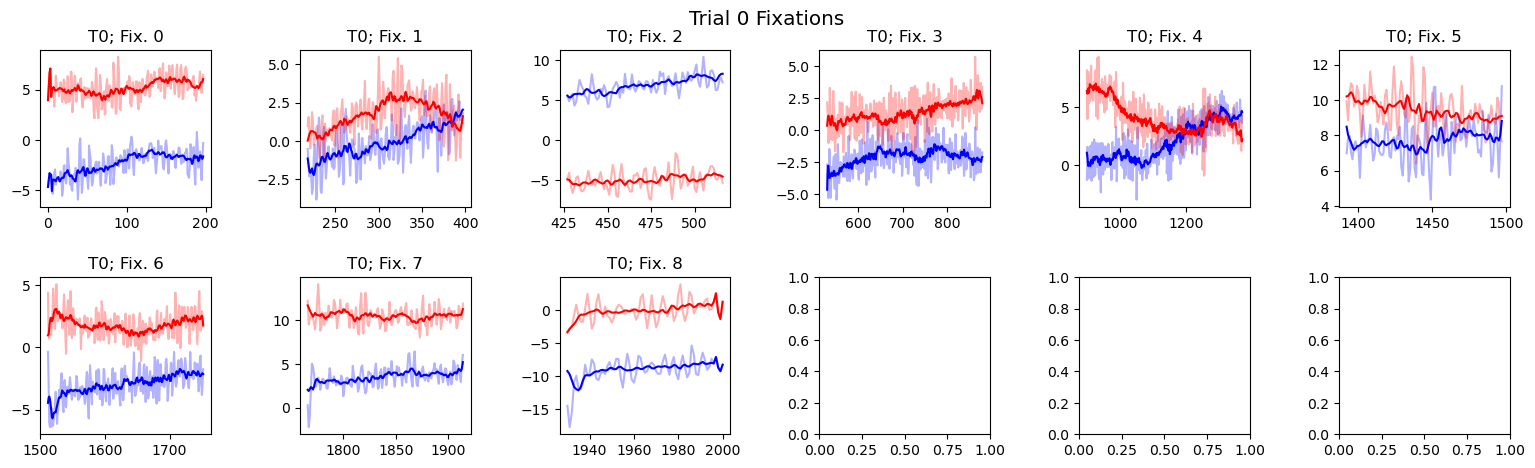

In [76]:
''' Process and plot a single trial. '''

tr = 0

if (data.processed[tr,0] == 0):
    data.process_trial(tr)
if (data.processed[tr,1] == 0):
    data.process_fixations(tr)
    
data.plot_trial(tr)
data.plot_saccades(tr, c=6, rh=2.5)
data.plot_fixations(tr, c=6, rh=2.5)

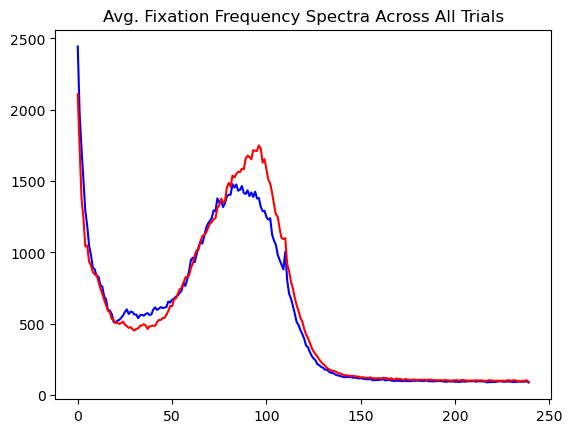

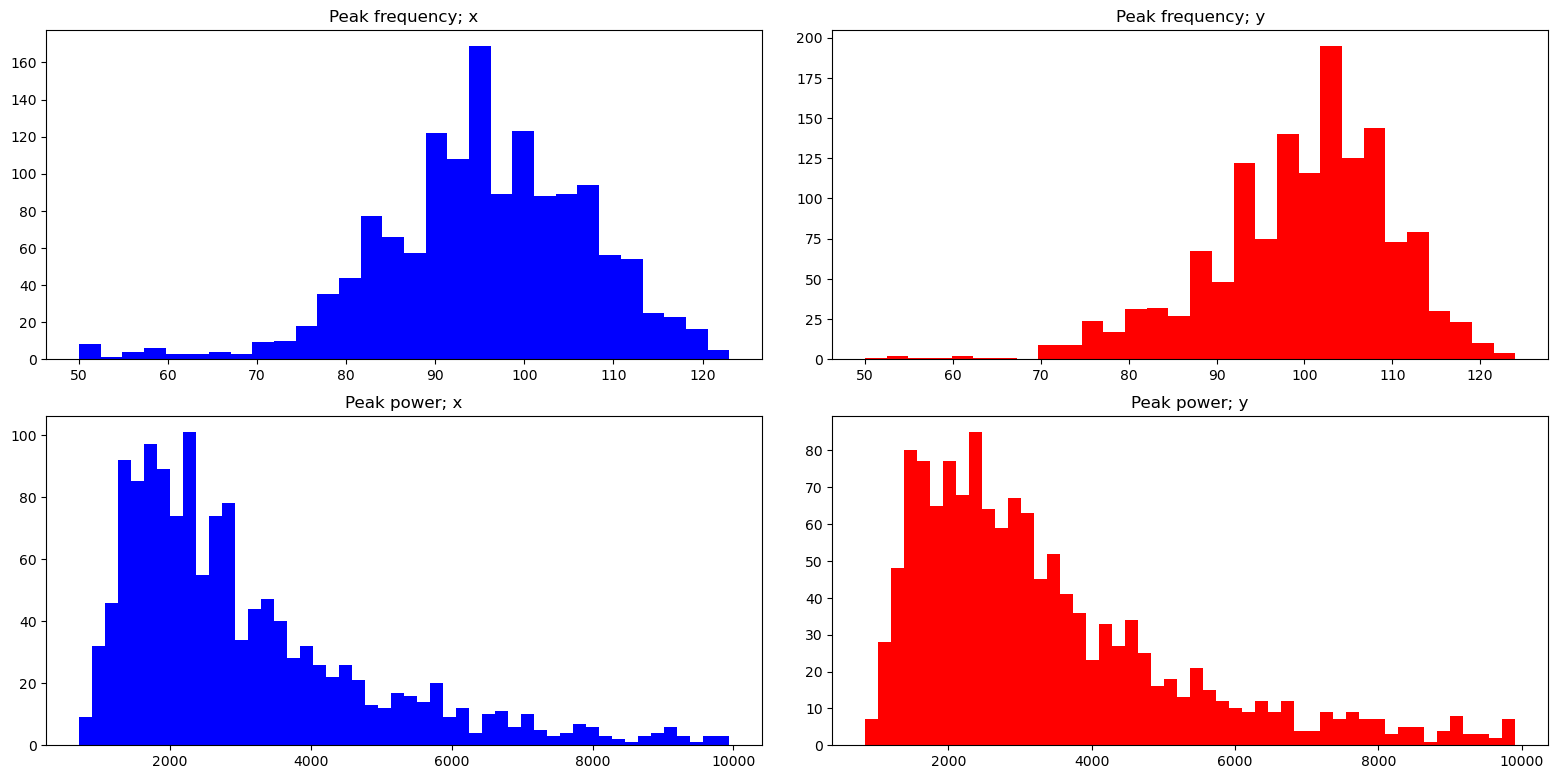

In [6]:
''' Calculate and plot average frequency spectra for entire experiment. '''

data.fft_fixations(to_plot=2)

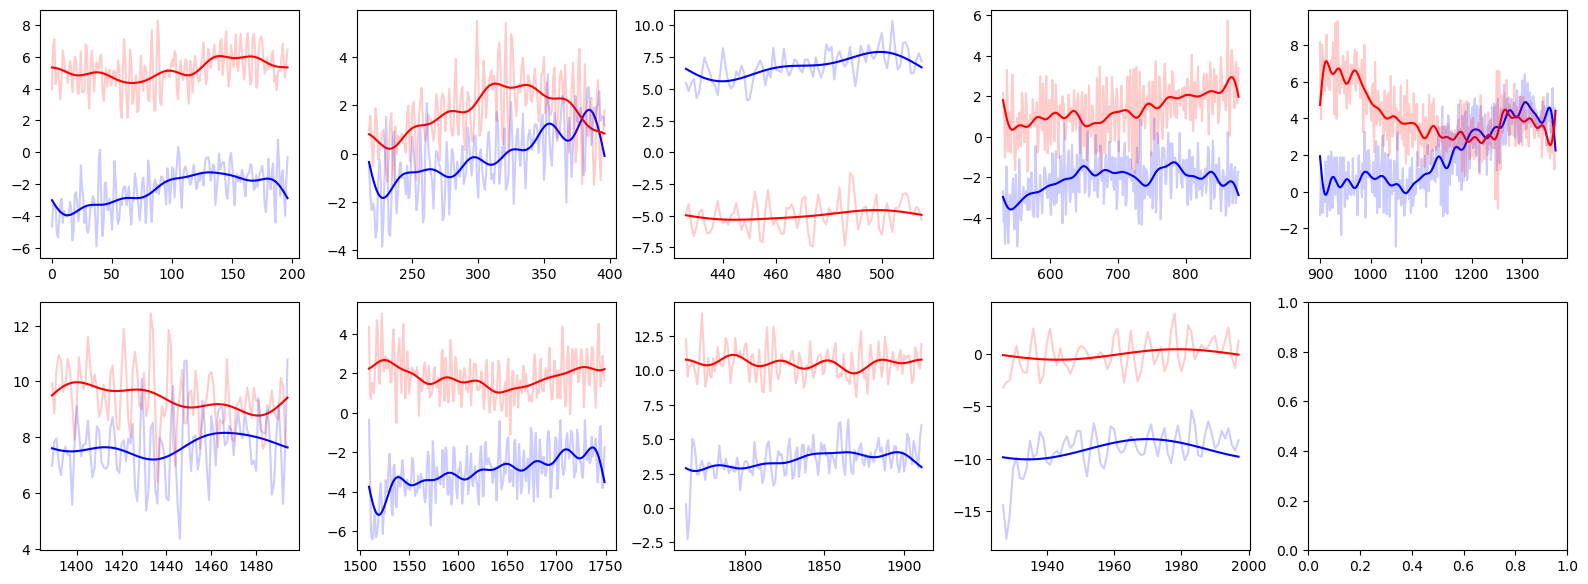

In [52]:
''' Apply low-pass filter (hard cutoff) to each fixation of the trial. '''

c = 5
r = math.ceil(len(data.fix_et[tr])/c)
lowcut = 20
full_filt = deepcopy(data.trial_avg_et[tr])

DU.ss(r, c, row_height=3)
for i, fix in enumerate(data.fix_et[tr]):
    nt = int(fix.shape[0])
    t = range(int(data.fix_dt[tr][i][0]), int(data.fix_dt[tr][i][1]))
    t = [int(x) for x in t]
    et_x = fix[:,1]
    et_y = fix[:,2]
    et_xf = rfft(et_x)
    et_yf = rfft(et_y)
    tf = rfftfreq(nt, data.dt)
    idx = int(lowcut * len(tf) / (0.5 * 1/data.dt))
    et_xf[idx:] = 0
    et_yf[idx:] = 0
    et_x_filt = irfft(et_xf, n=nt)
    et_y_filt = irfft(et_yf, n=nt)
    full_filt[t,1] = et_x_filt
    full_filt[t,2] = et_y_filt
    plt.subplot(r, c, i+1)
    plt.plot(t, et_x_filt, color='blue')
    plt.plot(t, et_y_filt, color='red')
    plt.plot(t, fix[:,1], alpha=0.2, color='blue')
    plt.plot(t, fix[:,2], alpha=0.2, color='red')

plt.show()

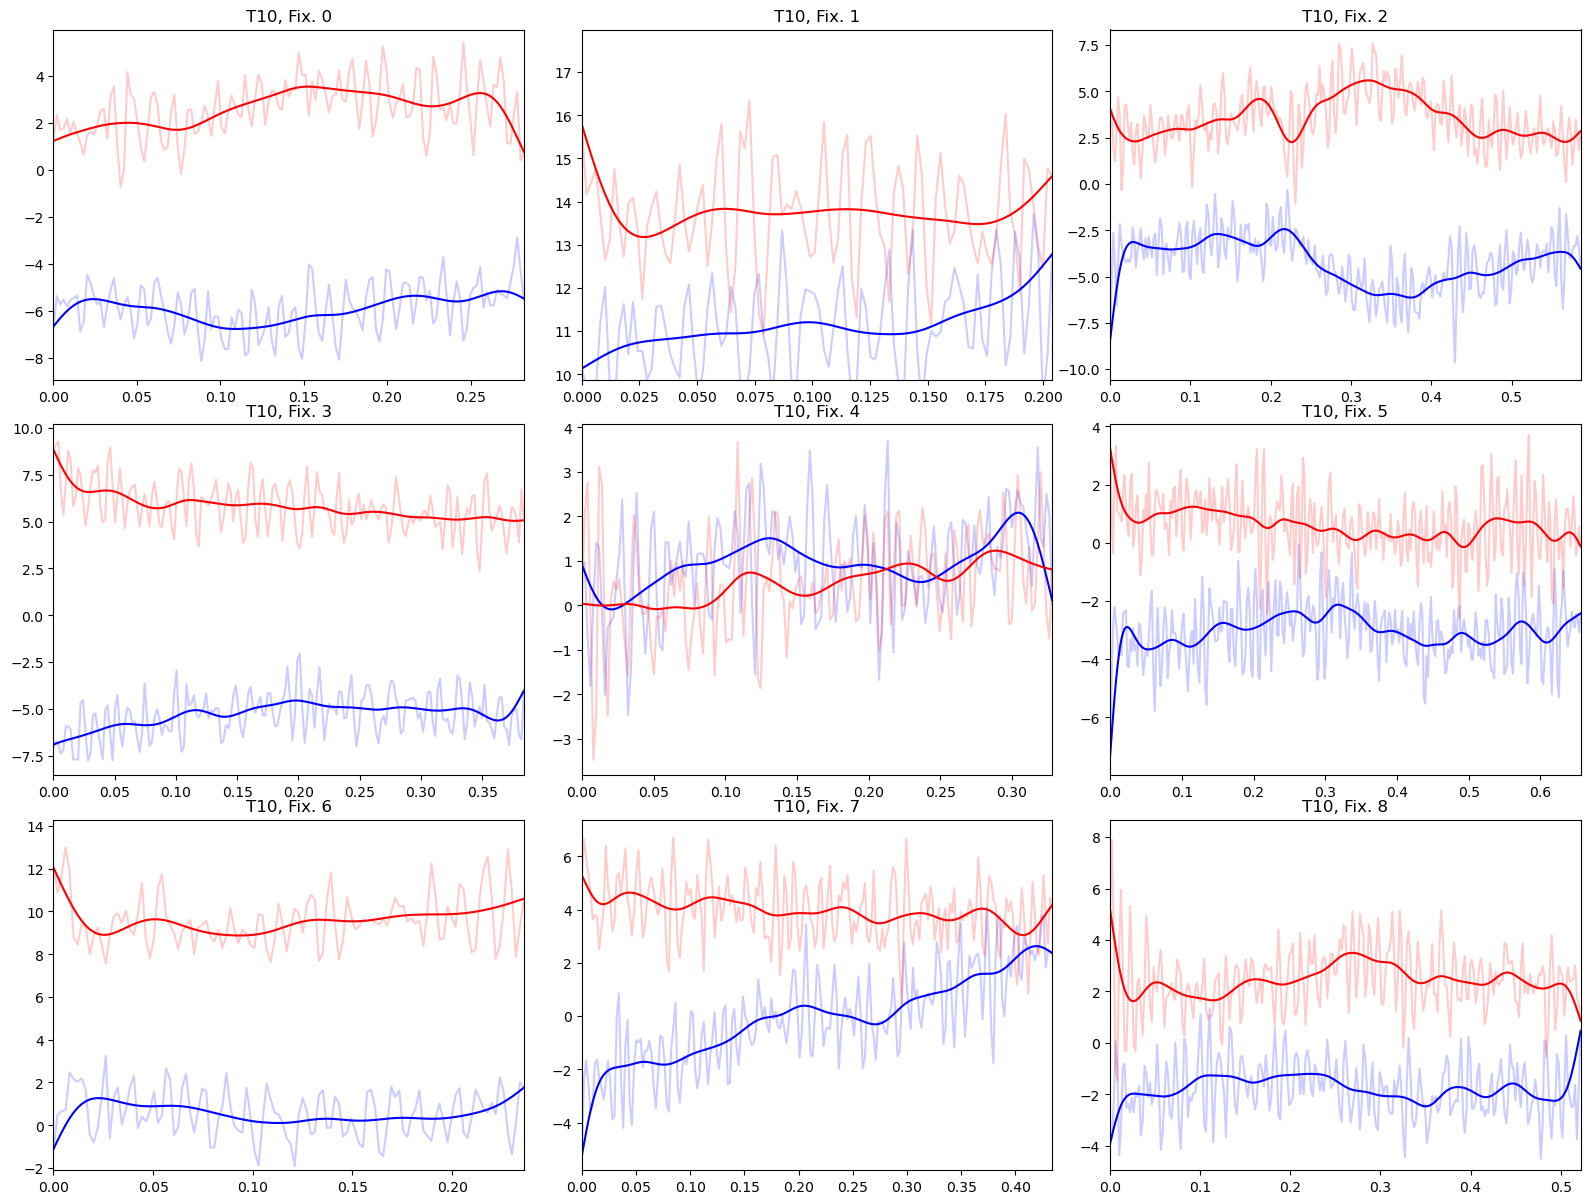

In [29]:
''' Apply low-pass Butterworth filter to each fixation of the trial. '''

c = 3
r = math.ceil(len(data.fix_et[tr])/c)
lowcut = 20
order = 3
nyq = 0.5 / data.dt
low = lowcut / nyq
b, a = signal.butter(order, low, btype='lp')

fig = DU.ss(r, c, rh=4)
for i, fix in enumerate(data.fix_et[tr]):
    n = fix.shape[0]
    if n > 50:
        plt.subplot(r, c, i+1)
        t = np.linspace(0, n*data.dt, n)
        et_x = fix[:,1]
        et_y = fix[:,2]

        et_x_filt = signal.filtfilt(b, a, et_x)
        et_y_filt = signal.filtfilt(b, a, et_y)

        plt.plot(t, et_x, color='blue', alpha=0.2)
        plt.plot(t, et_y, color='red', alpha=0.2)
        plt.plot(t, et_x_filt, color='blue', alpha=1)
        plt.plot(t, et_y_filt, color='red', alpha=1)
        plt.title(f'T{tr}, Fix. {i}')
        plt.axis([0, n*data.dt, fix[:,1:].min()*1.1, fix[:,1:].max()*1.1])
plt.show()

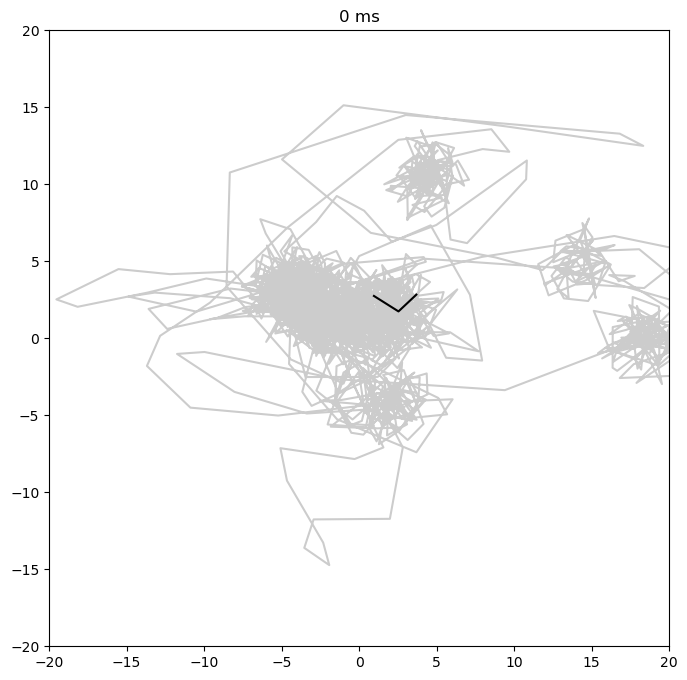

In [80]:
''' Plot and save GIF of the trial. Takes about 4 min. for a full trial. '''

trail = 3
tr = 1

x, y = [], []
prev_x, prev_y = [], []
fig, ax = plt.subplots(figsize=(8,8))

def animate(i):
    x = data.trial_et[tr][i:i+trail,1]
    y = data.trial_et[tr][i:i+trail,2]
    prev_x.append(data.trial_et[tr][i,1])
    prev_y.append(data.trial_et[tr][i,2])
    plt.cla()
    ax.plot(x, y, color='black')
    ax.plot(prev_x, prev_y, color='black', alpha=0.2)
    ax.set_xlim([-20,20])
    ax.set_ylim([-20,20])
    ax.set_title(f'{int(2*i)} ms')

ani = FuncAnimation(fig, animate, frames=data.trial_et[tr].shape[0]-trail, interval=20, repeat=False)
ani.save(f't{tr}_et.gif')

In [54]:
''' Perform wavelet decompositions. '''
new_pow_x, new_pow_y = [], []
freqs = np.array([20, 40, 60, 80, 90, 100, 110, 120, 140, 160])
scale = pywt.frequency2scale('cmor1.5-1.0', freqs * data.dt)

for i, fix in enumerate(data.fix_et[tr]):
    fix_x = fix[:,1]
    fix_y = fix[:,2]

    t = fix.shape[0]
    fix_xr = np.flip(fix_x)
    fix_yr = np.flip(fix_y)
    fix_x = np.concatenate([fix_xr, fix_x, fix_xr])
    fix_y = np.concatenate([fix_yr, fix_y, fix_yr])

    wav = pywt.ContinuousWavelet('cmor1.5-1.0')

    out_x = pywt.cwt(fix_x , scale, wav)[0][:,t:2*t]
    out_y = pywt.cwt(fix_y , scale, wav)[0][:,t:2*t]

    wavelet_out_x = np.abs(out_x)
    wavelet_out_y = np.abs(out_y)
    new_pow_x.append(wavelet_out_x**2)
    new_pow_y.append(wavelet_out_y**2)

In [55]:
''' Combine decompositions into full trial. '''

full_fix_wavelet = np.zeros([data.trial_et[tr].shape[0],10,2])
last1 = 0

for i, sacc in enumerate(data.sacc_dt[tr]): 
    full_fix_wavelet[last1:int(sacc[0]),:,0] = new_pow_x[i].T
    full_fix_wavelet[last1:int(sacc[0]),:,1] = new_pow_y[i].T
    last1 = int(sacc[1])+1

full_fix_wavelet[last1:,:,0] = new_pow_x[i+1].T
full_fix_wavelet[last1:,:,1] = new_pow_y[i+1].T



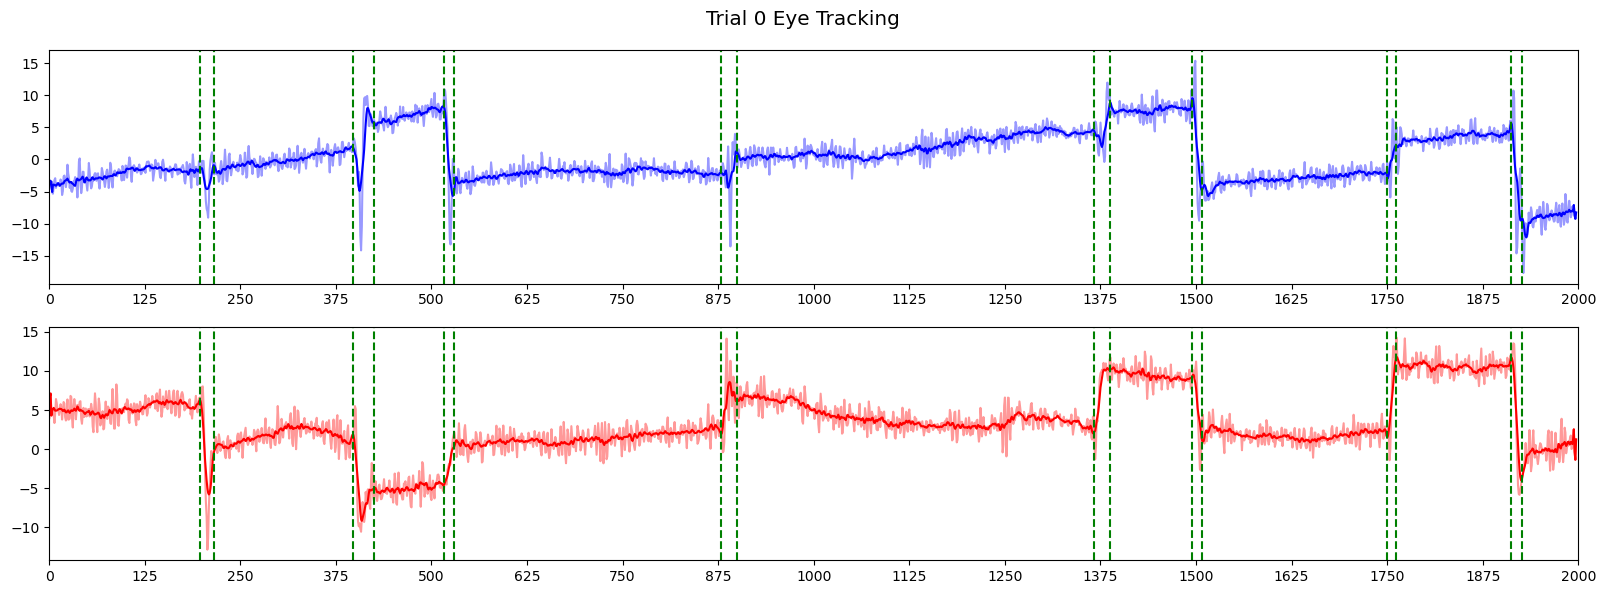

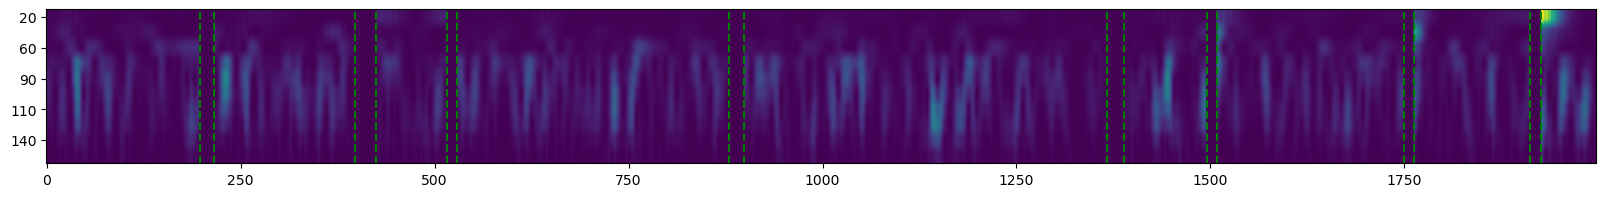

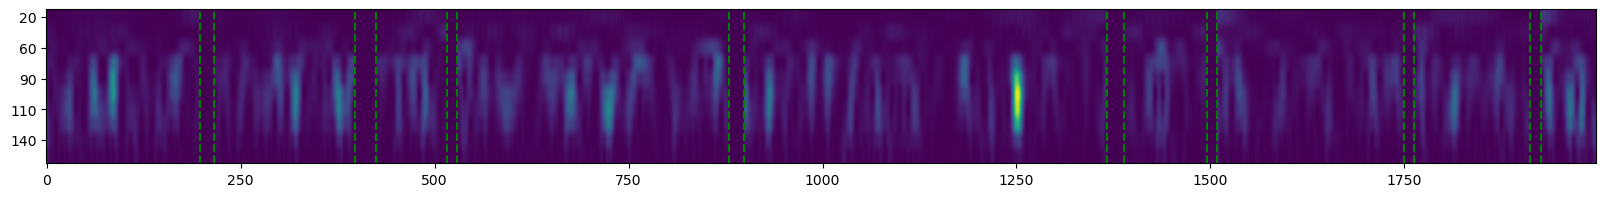

In [56]:
''' Plot wavelet decompositions. '''

data.plot_trial(tr)

fig, ax = plt.subplots(figsize=(20, 2))
ax.imshow(full_fix_wavelet[:,:,0].T, aspect='auto')
plt.yticks([2*i for i in range(5)],[freqs[i] for i in range(10) if i%2 == 0])
for sacc in data.sacc_dt[tr]:
    plt.axvline(x=sacc[0], color='green', linestyle='dashed', alpha=1)
    plt.axvline(x=sacc[1], color='green', linestyle='dashed', alpha=1)
plt.show()

fig, ax = plt.subplots(figsize=(20, 2))
ax.imshow(full_fix_wavelet[:,:,1].T, aspect='auto')
plt.yticks([2*i for i in range(5)],[freqs[i] for i in range(10) if i%2 == 0])
for sacc in data.sacc_dt[tr]:
    plt.axvline(x=sacc[0], color='green', linestyle='dashed', alpha=1)
    plt.axvline(x=sacc[1], color='green', linestyle='dashed', alpha=1)
plt.show()

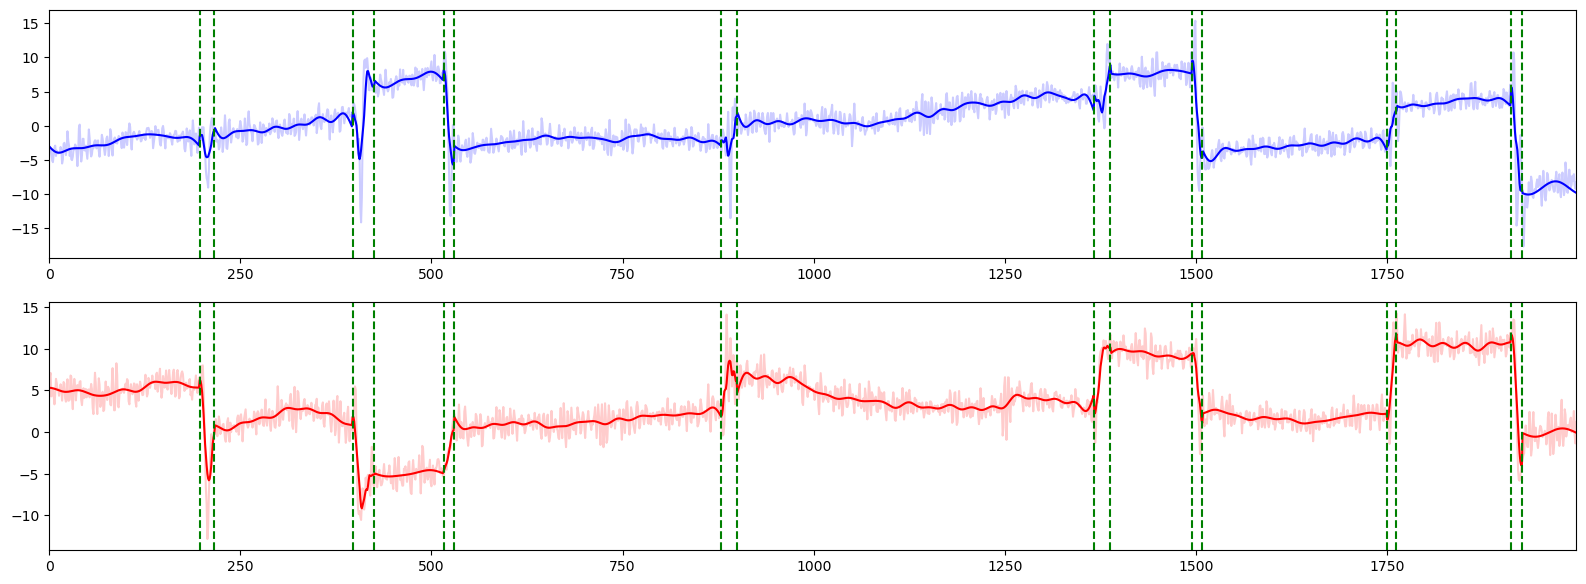

In [57]:
''' Plot filtered trial. '''

DU.ss(2,1,rh=3)

plt.subplot(211)
plt.margins(x=0)
plt.plot(full_filt[:,1], color='blue')
plt.plot(data.trial_et[tr][:,1], alpha=0.2, color='blue')
for sacc in data.sacc_dt[tr]:
    plt.axvline(x=sacc[0], color='green', linestyle='dashed', alpha=1)
    plt.axvline(x=sacc[1], color='green', linestyle='dashed', alpha=1)
    
plt.subplot(212)
plt.margins(x=0)
plt.plot(full_filt[:,2], color='red')
plt.plot(data.trial_et[tr][:,2], alpha=0.2, color='red')
for sacc in data.sacc_dt[tr]:
    plt.axvline(x=sacc[0], color='green', linestyle='dashed', alpha=1)
    plt.axvline(x=sacc[1], color='green', linestyle='dashed', alpha=1)
plt.show()

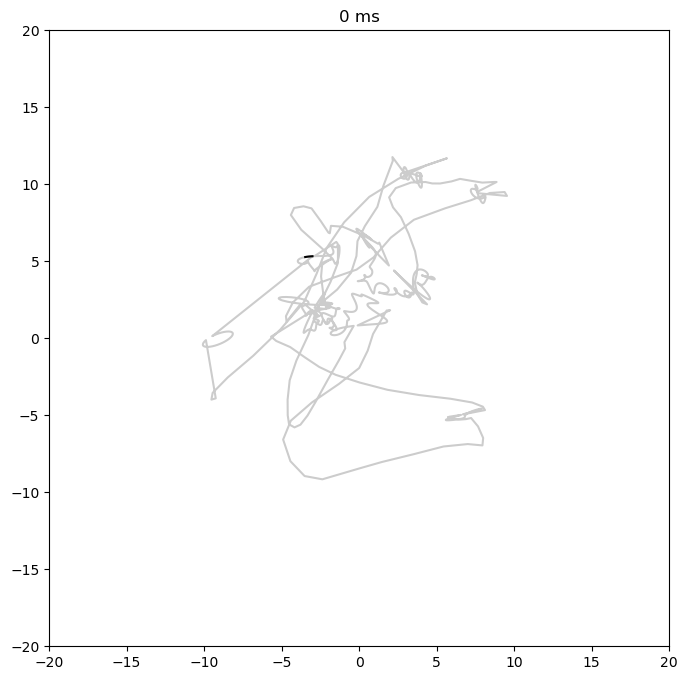

In [58]:
''' Plot and save GIF of the trial. Takes about 4 min. for a full trial. '''

trail = 5

x, y = [], []
prev_x, prev_y = [], []
fig, ax = plt.subplots(figsize=(8,8))

def animate(i):
    x = full_filt[i:i+trail,1]
    y = full_filt[i:i+trail,2]
    prev_x.append(full_filt[i,1])
    prev_y.append(full_filt[i,2])
    plt.cla()
    ax.plot(x, y, color='black')
    ax.plot(prev_x, prev_y, color='black', alpha=0.2)
    ax.set_xlim([-20,20])
    ax.set_ylim([-20,20])
    ax.set_title(f'{int(2*i)} ms')

ani = FuncAnimation(fig, animate, frames=full_filt.shape[0]-trail, interval=20, repeat=False)
ani.save(f't{tr}_et_filtered.gif')